# Introduction

Getting familiar with the first few stages of biological visual processing.

In [193]:
import matplotlib
matplotlib.use('Agg')

import numpy as np
import h5py
from scipy.stats import zscore
from pyret.spiketools import binspikes
# from deepretina.toolbox import load_model, load_partial_model, rolling_window
# from deepretina.io import despine
# from deepretina.metrics import cc

%matplotlib inline
from matplotlib.pyplot import *
import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Will package this up... aesthetics

In [222]:
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

## Load bipolar cell membrane potential data  
  
A single bipolar cell's response to a Gaussian white noise visual stimulus presented twice. One pair of responses are to a 35% contrast stimulus, the other pair to a 5% contrast stimulus.

Data from David Kastner and Stephen Baccus, "Spatial Segregation of Adaptation and Predictive Sensitization in Retinal Ganglion Cells." *Neuron*. Volume 79, Issue 3. August 2013.

In [294]:
bipolar_cell_h1 = np.loadtxt('data/bipolarcell_h1.txt', skiprows=1)
bipolar_cell_h2 = np.loadtxt('data/bipolarcell_h2.txt', skiprows=1)
sampling_rate = 1000.
time = np.linspace(0,len(bipolar_cell_h1)/sampling_rate, len(bipolar_cell_h1))

In [295]:
bipolar_cell_l1 = np.loadtxt('data/bipolarcell_l1.txt', skiprows=1)
bipolar_cell_l2 = np.loadtxt('data/bipolarcell_l2.txt', skiprows=1)
sampling_rate = 1000.
time = np.linspace(0,len(bipolar_cell_l1)/sampling_rate, len(bipolar_cell_l1))

### What does the variability look like?

#### High contrast (high SNR)

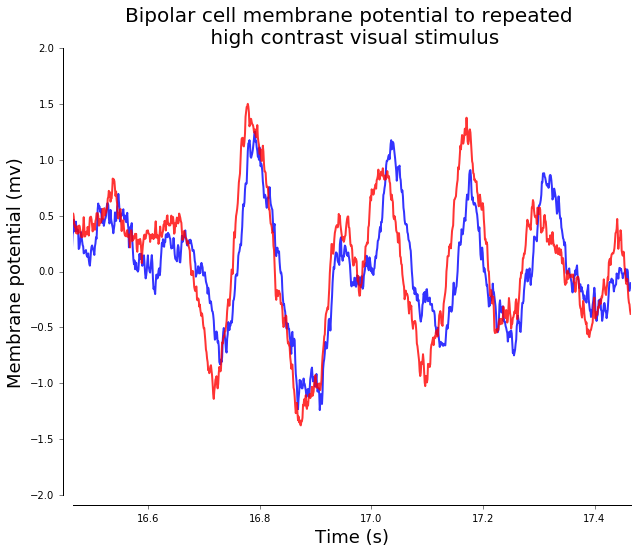

In [332]:
plt.plot(time, bipolar_cell_h1, 'b', linewidth=2, alpha=0.8)
plt.plot(time, bipolar_cell_h2, 'r', linewidth=2, alpha=0.8)
plt.title('Bipolar cell membrane potential to repeated \n high contrast visual stimulus', fontsize=20)
plt.ylabel('Membrane potential (mv)', fontsize=18)
plt.xlabel('Time (s)', fontsize=18)

# display random 1 second of data
random_start_time = np.random.choice(time[time < np.max(time)-1])
plt.xlim([random_start_time,random_start_time+1])

# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

#### Low contrast (low SNR)

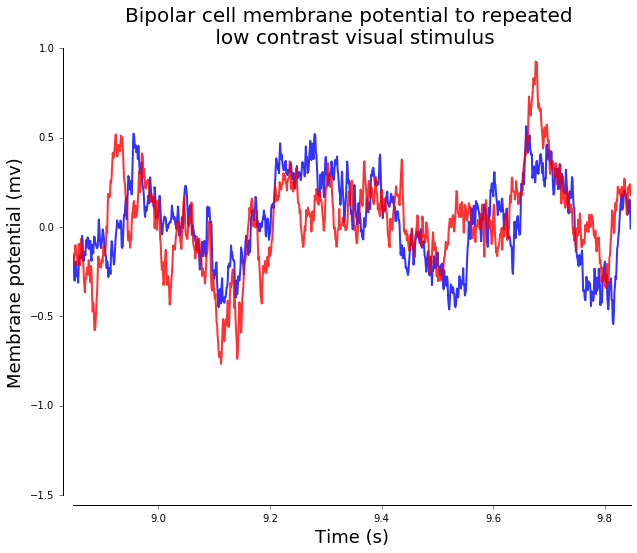

In [331]:
plt.plot(time, bipolar_cell_l1, 'b', linewidth=2, alpha=0.8)
plt.plot(time, bipolar_cell_l2, 'r', linewidth=2, alpha=0.8)
plt.title('Bipolar cell membrane potential to repeated \n low contrast visual stimulus', fontsize=20)
plt.ylabel('Membrane potential (mv)', fontsize=18)
plt.xlabel('Time (s)', fontsize=18)

# display random 1 second of data
random_start_time = np.random.choice(time[time < np.max(time)-1])
plt.xlim([random_start_time,random_start_time+1])

# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

#### Plot the residuals versus the mean.

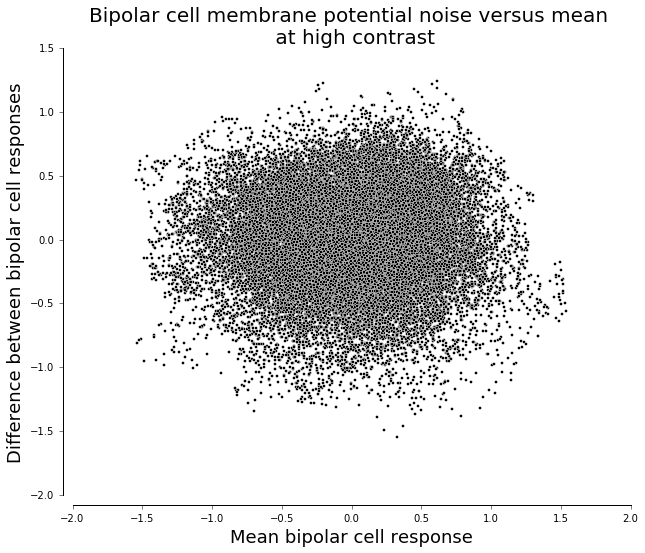

In [328]:
plt.plot(np.mean(np.stack([bipolar_cell_h1, bipolar_cell_h2]), axis=0), bipolar_cell_h1-bipolar_cell_h2,
        'k.', mec='w', mew=0.4)
plt.title('Bipolar cell membrane potential noise versus mean \n at high contrast', fontsize=20)
plt.xlabel('Mean bipolar cell response', fontsize=18)
plt.ylabel('Difference between bipolar cell responses', fontsize=18)
# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

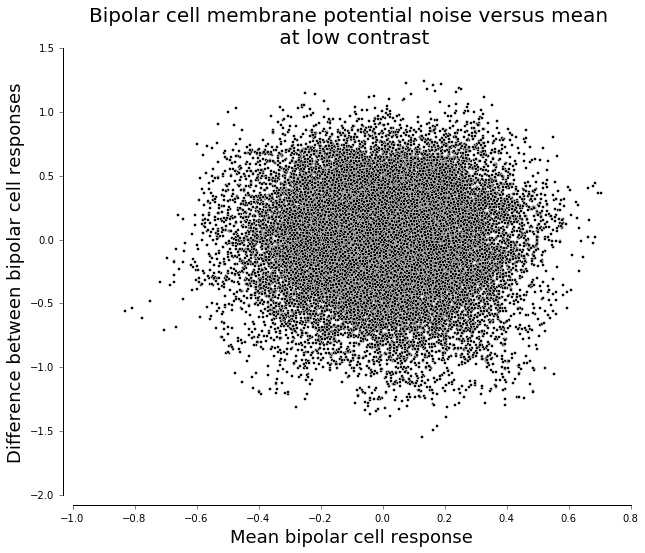

In [329]:
plt.plot(np.mean(np.stack([bipolar_cell_l1, bipolar_cell_l2]), axis=0), bipolar_cell_h1-bipolar_cell_h2,
        'k.', mec='w', mew=0.4)
plt.title('Bipolar cell membrane potential noise versus mean \n at low contrast', fontsize=20)
plt.xlabel('Mean bipolar cell response', fontsize=18)
plt.ylabel('Difference between bipolar cell responses', fontsize=18)
# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

## Load retinal dataset with 112 repeats of 30s natural scenes

In [223]:
with h5py.File('/Users/lmcintosh/experiments/data/16-05-31/naturalscene.h5', 'r') as h:
    stimulus = np.array(np.array(h['test/stimulus']))
    psth = np.array(h['test/response/firing_rate_10ms'])
    repeats = np.stack([np.array(h['test/repeats/%s' %key]) for key in sorted(h['test/repeats'].keys())])
    time = np.array(h['test/time'])

## Visual stimulus

In [224]:
stimulus.shape

(3003, 50, 50)

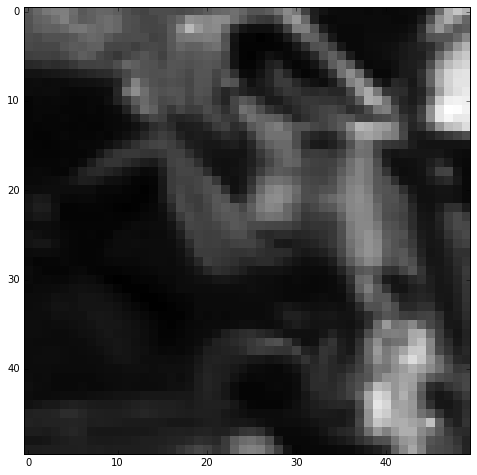

In [227]:
plt.imshow(stimulus[200])

## What does the average output of the retina look like?

In [228]:
psth.shape

(28, 3003)

#### Visualize average responses of all 28 cells for first 5 seconds of each repeat

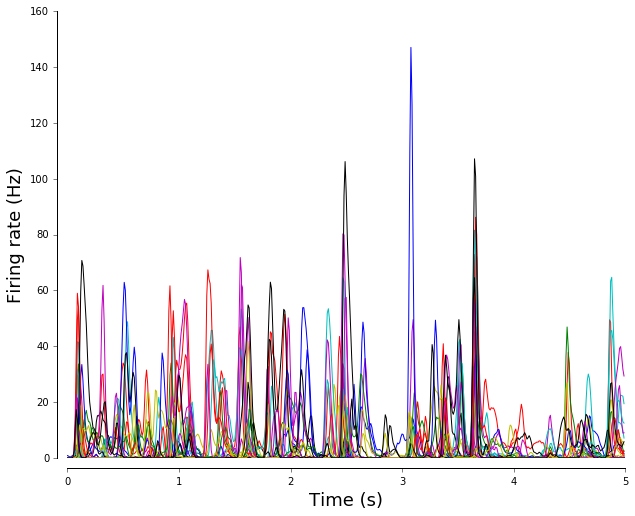

In [229]:
p = plt.plot(time[:500], psth[:,:500].T)
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Firing rate (Hz)', fontsize=18)
# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

#### Qualitatively look at how change of natural scene every 1s relates to retinal firing for example cell

(0, 5)

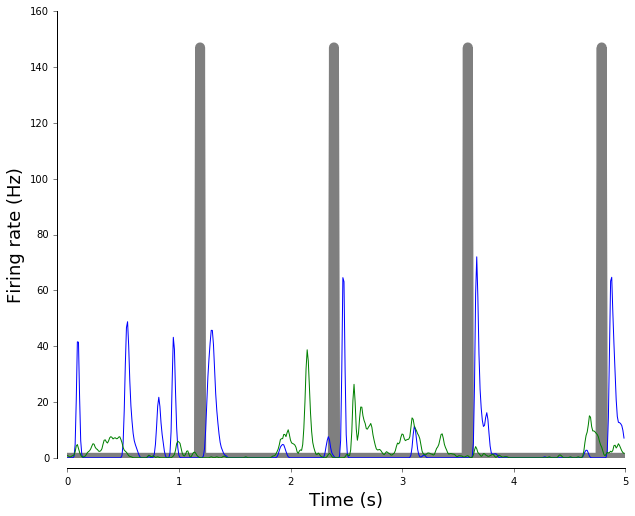

In [230]:
# Plot mean difference between frames
mean_stimulus_difference = abs(np.mean(np.diff(stimulus.astype('float32'), axis=0), axis=(1,2)))
plt.plot(time[:-1], np.max(psth)*np.where(mean_stimulus_difference > 2*np.std(mean_stimulus_difference), 1, 0), 
         'k', linewidth=10, alpha=0.5)

p = plt.plot(time[:500], psth[3,:500].T)
p = plt.plot(time[:500], psth[0,:500].T)
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Firing rate (Hz)', fontsize=18)

# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])
plt.xlim([0,5])

# A simple linear-nonlinear model of retinal responses

In [231]:
with h5py.File('/Users/lmcintosh/experiments/data/16-05-31/whitenoise.h5', 'r') as h:
    whitenoise = np.array(np.array(h['test/stimulus']))
    whitenoise_psth = np.array(h['test/response/firing_rate_10ms'])
    whitenoise_time = np.array(h['test/time'])

## TODO: compute linear receptive field

## TODO: compute actual vs predicted response to get nonlinearity

## TODO: fit sigmoid to actual-predicted plot

## TODO: compute correlation between response and LN predictions

## TODO: show how this doesn't generalize well to predicting natural scene responses

## Characterizing retinal noise

In [232]:
repeats.shape

(28, 112, 3003)

#### Raster of first cell

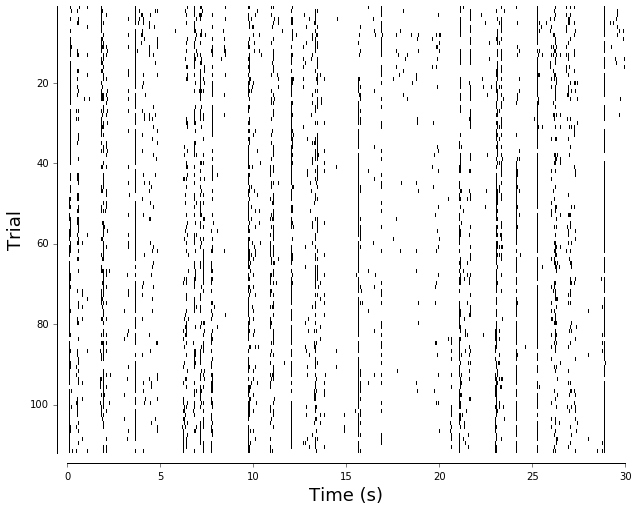

In [237]:
plt.imshow(repeats[20], aspect='auto', clim=[0,1], cmap='gray_r', extent=(time[0], time[-1], repeats.shape[1], 1))
plt.xlabel('Time (s)', fontsize=18)
plt.ylabel('Trial', fontsize=18)
# aesthetics
plt.tick_params(axis='y', direction='out')
plt.tick_params(axis='x', direction='out')
adjust_spines(plt.gca(), ['left', 'bottom'])

#### Get coarser bins

In [216]:
# spike_times = np.where(repeats[0], time, 0)
# coarse_bins = np.stack([binspikes(repeats[0,i], binsize=0.1, time=np.linspace(0,time[-1],300)) for i in range(repeats.shape[1])])
# coarse_time = coarse_bins[0,1,:]
# coarse_bins = coarse_bins[:,0,:].squeeze()

In [238]:
var_spike_count = np.var(repeats[0], axis=0)
mean_spike_count = np.mean(repeats[0], axis=0)

In [239]:
np.mean(var_spike_count)

0.020466857759587346

In [240]:
np.mean(mean_spike_count)

0.022129656058227486

In [241]:
cartoon_mean_spike_count = 2.0
cartoon_var_spike_count = 0.8

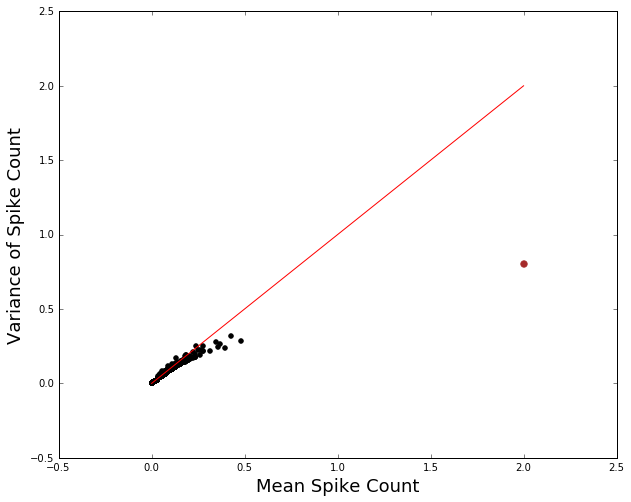

In [242]:
plt.scatter(mean_spike_count, var_spike_count, color='k')
plt.plot(np.linspace(0,2,10), np.linspace(0,2,10), color='r')
plt.scatter(cartoon_mean_spike_count, cartoon_var_spike_count, color='brown', s=40)
plt.xlabel('Mean Spike Count', fontsize=18)
plt.ylabel('Variance of Spike Count', fontsize=18)

## Compute scaling relationship

In [173]:
# nbins = 8
# n, _ = np.histogram(mean_spike_count, bins=nbins)
# sy, _ = np.histogram(mean_spike_count, bins=nbins, weights=var_spike_count)
# sy2, xs = np.histogram(mean_spike_count, bins=nbins, weights=np.array(var_spike_count)**2)
# mean = sy / n
# std = np.sqrt(sy2/n - mean*mean)

# plt.errorbar((xs[1:] + xs[:-1])/2, mean, yerr=std, fmt='r-', linewidth=4)